# Info
created by Marlene 

edited by Weisong since Dec 2, 2024
a new version of order_request_cleanup.ipynb (created on Jan 15, 2025)

purpose: read in data that covers all 4 blood products & create monthly performance matrix (a large data frame that combines all products and stats)
# Pipeline
1. Read clinician request data, included 4 types of products
2. created mo_ds.pkl to store
3. create the timetrend_prbc_req_before_added.csv that is used in timetrend_visualization
# Variables
1. datam: first created by merging data_df & prbc_req_final
2. 

In [9]:
!pip install plotly

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pkl
from datetime import timedelta
from matplotlib_venn import venn2
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix
import sys
import plotly.graph_objects as go
import matplotlib.dates as mdates
import datetime
import importlib
import pickle
pio.renderers.default = 'iframe'

In [2]:
#!pip install plotly #run if not installed

# Read in data
- prbc_req: grain = prepare order, contains enc_id, episode_id, sign_time, result_time, needed_date, prbc_units_requested 
- data_df: grain = anethesia episode, contains scheduled_date, prbc reserved units, prbc requested units, prbc transfused units, episode_id, mrn_id 
- extra:  grain = anethesia episode, contains anes_start, in_room, out_of_room time (left merged to data_df) 
- ts: grain = type&screen order, contains sign_time, result_time, specimen_collected_time, specimen_received_time, procedure name, and episode_id


In [3]:
rae_folder = "N:/Data/20250502" #O:\Data\20230828
cur_commit = 'b783a43'
cur_commit2 = '4da9286'

In [7]:
extra = pd.read_csv(f'{rae_folder}/extra_timestamps_longFormat_{cur_commit}.csv').drop_duplicates()
# Convert extra
for i in ['in_room_tsp', 'anes_start_tsp','out_of_room_tsp']:
   extra[i] = pd.to_datetime(extra[i], utc=True) 

# Filtering 

## All_req (from Clinician Requests)


In [4]:
## read in data of clinician request
all_req = pd.read_csv(f'{rae_folder}/requested_bloodproducts_query_longFormat_{cur_commit}.csv').drop_duplicates()
print(f'Total before filtering: {len(all_req)}')
# Convert products req date time
for i in ['sign_time', 'result_time','needed_date']:
   all_req[i] = pd.to_datetime(all_req[i], utc=True) 
# merge with extra timepoints
all_req = all_req.merge(extra.drop('retrospective_or_prd',axis=1), on='deid_case_id', how='left')
# drop rows with missing anes_start
all_req = all_req[~all_req.anes_start_tsp.isna()]
# if out of room time present must be after in room
all_req = all_req[all_req['out_of_room_tsp'].isna() | (all_req['in_room_tsp'] < all_req['out_of_room_tsp'])] 
# if result time present must be no later than sign
all_req = all_req[all_req['result_time'].isna() | (all_req['sign_time'] <= all_req['result_time'])]
# this copy is to check data when same day filter is not applied
all_not = all_req.copy()
# same day filter: in room /case start happen the same date as request needed
all_req['days_diff'] = (all_req['in_room_tsp'].dt.date - all_req['needed_date'].dt.date) 
all_same = all_req[all_req['days_diff']==datetime.timedelta(0)]
print('Needed date same as in-room :'+str(len(all_same)))
all_req = all_same.copy()
all_same.isna().sum()

Total before filtering: 200126
Needed date same as in-room :51150


deid_case_id               0
retrospective_or_prd       0
sign_time                  0
result_time             3892
needed_date                0
blood_product              0
units_requested           64
in_room_tsp                0
anes_start_tsp             0
out_of_room_tsp            0
days_diff                  0
dtype: int64

In [5]:
# see the names of blood products
#blood_product_list = (list(set(all_req.get('blood_product', []))))
blood_product_list = ['prbc', 'ffp', 'platelets']

In [6]:
#see if duplicate in case_id from clinician request
if all_req['deid_case_id'].duplicated().any():
    print("There are duplicates in 'col1'")
else:
    print("No duplicates found in 'col1'")
# there are duplicate meaning there is such a case that multiple products ordered.

There are duplicates in 'col1'


In [5]:
# Take one product from all products
#all_req = all_req[all_req['blood_product'] == 'platelets']
#all_same = all_same[all_same['blood_product'] == 'platelets']

### sign time check

In [5]:
# not sure where these variables will be used
# filter based on when sign time happens - no later than anes start
prbc_before =  prbc_req[(prbc_req['sign_time'] <= prbc_req['anes_start_tsp']) ] 
# no later than in room but after anes start
prbc_between =  prbc_req[(prbc_req['sign_time'] <= prbc_req['in_room_tsp']) & (prbc_req['sign_time'] > prbc_req['anes_start_tsp'])] 
# after in room but no later than out of room+6h
prbc_after = prbc_req[(prbc_req['sign_time'] > prbc_req['in_room_tsp']) & (prbc_req['sign_time'] <= prbc_req['out_of_room_tsp'])] # + pd.Timedelta(hours=6)

print(f'Total: {len(prbc_req)}')
print(f'sign < anesthesia start: {len(prbc_before)}')
print(f'anesthesia start <= sign < in-room: {len(prbc_between)}')
print(f'in-room <= sign <= 6hr out of room: {len(prbc_after)}')
#print("both sign and result before anes start: "+str(len(prbc_before)))
#print("both sign and result after anes start: "+str(len(prbc_after)))
#print("sign -> anes start -> result: "+str(len(prbc_between))) 

Total: 26672
sign < anesthesia start: 11410
anesthesia start <= sign < in-room: 689
in-room <= sign <= 6hr out of room: 14237


### time diff

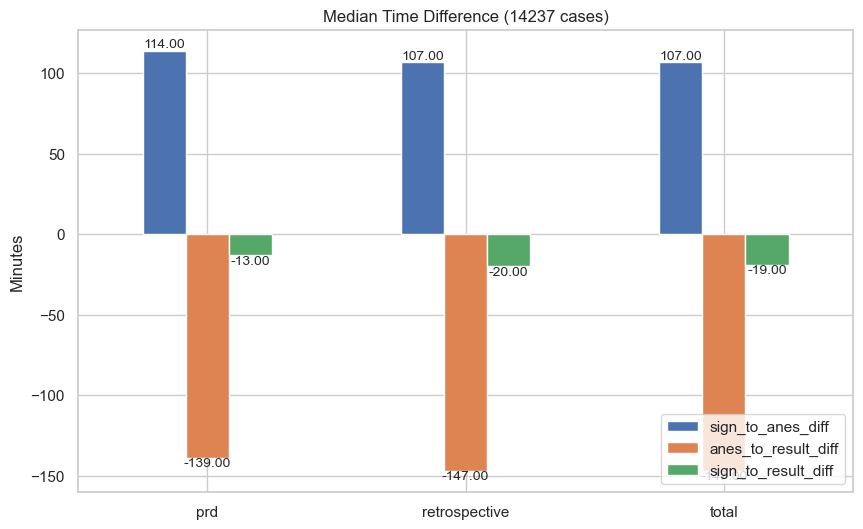

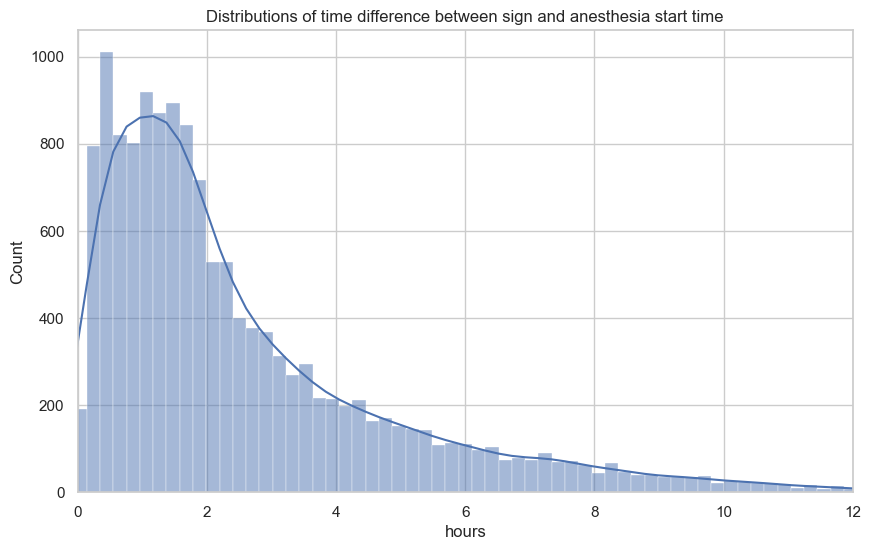

In [6]:
 # visualize time difference
df = prbc_after.copy()
#df = df[df['sign_time'] <= df['in_room_tsp'].dt.floor('D')]
# Calculate the time differences - in minutes
df['sign_to_anes_diff'] = (df['sign_time'] - df['anes_start_tsp']).dt.total_seconds() / 60 
df['anes_to_result_diff'] = (df['anes_start_tsp'] - df['result_time']).dt.total_seconds() / 60
df['sign_to_result_diff'] = (df['sign_time'] - df['result_time']).dt.total_seconds() / 60
 
diffs = ['sign_to_anes_diff', 'anes_to_result_diff', 'sign_to_result_diff']

sns.set(style="whitegrid")

# Group by 'retrospective_or_prd' and calculate median
grouped_median = df.groupby('retrospective_or_prd')[diffs].median()

# Calculate the median across the entire dataset (total)
total_median = df[diffs].median().to_frame().T
total_median.index = ['total']

# Append the total medians to the grouped medians
combined_medians = pd.concat([grouped_median, total_median])

# Create a bar plot with annotations for both groups and total
fig, ax = plt.subplots(figsize=(10, 6))
combined_medians.plot(kind='bar', ax=ax)

# Add annotations on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

ax.set_title(f'Median Time Difference ({len(df)} cases)')
ax.set_ylabel('Minutes')
ax.legend(loc='lower right')
plt.xticks(rotation=0)

# Distribution of differences between sign_time and in-room time
plt.figure(figsize=(10, 6))
sns.histplot(df['sign_to_anes_diff']/60, kde=True)
plt.title(f'Distributions of time difference between sign and anesthesia start time')
plt.xlabel('hours')
plt.xlim([0,12])
plt.show()

# Display missingness
missingness = df.isnull().sum()
#print(missingness)
 

In [7]:
# chek realtionship between in room and anesthesia start
# some anesthesia start time is the same as in room
# very few with anesthe after inroom
prbc_between =  prbc_same[(prbc_same['sign_time'] <= prbc_same['in_room_tsp']) & (prbc_same['sign_time'] >= prbc_same['anes_start_tsp'])] 
#prbc_between[['retrospective_or_prd','in_room_tsp','sign_time','anes_start_tsp','result_time','out_of_room_tsp']]


### create req any before variables

In [ ]:
all_req =  all_same.copy()
# Create the req before variable
 # Step 1: Calculate 'req_any_before_anes' and 'req_any_before_inroom'  
all_req['req_any_before_anes'] = (all_req['sign_time'] <= all_req['anes_start_tsp']).astype(int)
all_req['req_any_before_inroom'] = (all_req['sign_time'] <= all_req['in_room_tsp']).astype(int)
 # Step 2: define ref time point
all_req['anes_start_1hr_before'] = all_req['anes_start_tsp'] - pd.Timedelta(hours=1)
all_req['after_inroom_30m'] = all_req.apply(
    lambda row: row['out_of_room_tsp'] if row['out_of_room_tsp'] - row['in_room_tsp'] < timedelta(minutes=30) 
                else row['in_room_tsp'] + timedelta(minutes=30), axis=1
) # add another ref tp to be 30 minutes after inroom, if out of room is within 30 minutes of inroom (~case length)
all_req['after_inroom_1h'] = all_req.apply(
    lambda row: row['out_of_room_tsp'] if row['out_of_room_tsp'] - row['in_room_tsp'] < timedelta(minutes=60) 
                else row['in_room_tsp'] + timedelta(minutes=60), axis=1
)
all_req['in_room_1hr_before'] = all_req['in_room_tsp'] - pd.Timedelta(hours=1)
all_req['anes_start_1d_before'] = all_req['anes_start_tsp'].dt.floor('D') #- pd.Timedelta(days=1)
all_req['in_room_1d_before'] = all_req['in_room_tsp'].dt.floor('D') #- pd.Timedelta(days=1)
# Step 3: Calculate 'req_any_before for the rest
all_req['req_any_before_1hr_anes'] = (all_req['sign_time'] <= all_req['anes_start_1hr_before']).astype(int)
all_req['req_any_before_1d_anes'] = (all_req['sign_time'] <= all_req['anes_start_1d_before']).astype(int)
all_req['req_any_before_1hr_inroom'] = (all_req['sign_time'] <= all_req['in_room_1hr_before']).astype(int)
all_req['req_any_before_1d_inroom'] = (all_req['sign_time'] <= all_req['in_room_1d_before']).astype(int)
all_req['req_any_after_inroom_30m'] = (all_req['sign_time'] <= all_req['after_inroom_30m']).astype(int)
all_req['req_any_after_inroom_1h'] = (all_req['sign_time'] <= all_req['after_inroom_1h']).astype(int)

# Initialize an empty dictionary to store the results
results_dict = {}

for blood_product in blood_product_list:
    # Filter the DataFrame for the current blood product
    one_req = all_req[all_req['blood_product'] == blood_product]

    # Step 4: Group by 'deid_case_id' and aggregate to summarize the counts of requests and units
    one_req_final = one_req.groupby('deid_case_id').agg({
        'req_any_before_anes': 'max',  # Maximum value will give 1 if any request happened before ref tp, 0 otherwise
        'req_any_before_inroom': 'max',  
        'req_any_before_1d_anes':'max',
        'req_any_before_1d_inroom':'max',
        'req_any_before_1hr_anes': 'max',   
        'req_any_before_1hr_inroom': 'max',  
        'req_any_after_inroom_30m': 'max', 
        'req_any_after_inroom_1h': 'max',  
        'units_requested': [  # Sum total units requested before each time point for a case
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'anes_start_tsp']).sum(),
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'in_room_tsp']).sum(),
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'anes_start_1d_before']).sum(),
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'in_room_1d_before']).sum(),
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'anes_start_1hr_before']).sum(),
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'in_room_1hr_before']).sum(),
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'after_inroom_30m']).sum(),
            lambda x: (all_req.loc[x.index, 'sign_time'] <= all_req.loc[x.index, 'after_inroom_1h']).sum()
        ]
    }).reset_index()

    # Rename columns for clarity
    one_req_final.columns = [
        'deid_case_id', 
        'req_any_before_anes', 'req_any_before_inroom','req_any_before_1d_anes','req_any_before_1d_inroom',
        'req_any_before_1hr_anes', 'req_any_before_1hr_inroom','req_after_inroom_30m','req_after_inroom_1h',
        'req_units_before_anes', 'req_units_before_inroom','req_units_before_1d_anes','req_units_before_1d_inroom',
        'req_units_before_1hr_anes', 'req_units_before_1hr_inroom','req_units_after_inroom_30m','req_units_after_inroom_1h'
    ]

    # Store the result in the dictionary with the respective name
    results_dict[f'{blood_product}_req'] = one_req_final
    

In [21]:
# Save the results_dict as a pickle file in the current working directory
pickle_filename = 'clinician_orders.pkl'
with open(pickle_filename, 'wb') as file:
    pickle.dump(results_dict, file)

#prbc_req = prbc_req.merge(prbc_req_final,on='deid_case_id',how='left')
#prbc_req.drop(columns=['start_time', 'end_time','anes_start_tsp','out_of_room_tsp','in_room_tsp'], inplace=True)
#print(f'Total after filtering: {len(prbc_req_final)}')
#print(f'Missing: {prbc_req.isna().sum()}')
#print(f'PRBC unit requested stats: {prbc_req.prbc_units_requested.describe()}')

### count check

In [9]:
prbc_req=prbc_same.copy()
len(prbc_req[prbc_req.anes_start_tsp > prbc_req.in_room_tsp])

135

In [10]:
len(prbc_req[prbc_req.anes_start_tsp < prbc_req.in_room_tsp])

18972

In [11]:
len(prbc_req[prbc_req.anes_start_tsp == prbc_req.in_room_tsp])

7565

In [12]:
prbc_req_final[['req_after_inroom_1h','req_after_inroom_30m','req_any_before_inroom','req_any_before_anes',
    'req_any_before_1hr_inroom','req_any_before_1hr_anes','req_any_before_1d_inroom',
                'req_any_before_1d_anes']].apply(sum,axis=0)
#.drop_duplicates(subset='deid_case_id')

req_after_inroom_1h          15126
req_after_inroom_30m         13337
req_any_before_inroom        11275
req_any_before_anes          10643
req_any_before_1hr_inroom     5051
req_any_before_1hr_anes       4676
req_any_before_1d_inroom      1392
req_any_before_1d_anes        1391
dtype: int64

## data

In [5]:
re_col = ["race_ethnicity_asian",
"race_ethnicity_black",
"race_ethnicity_latinx",
"race_ethnicity_multi",
"race_ethnicity_native_am_alaska",
"race_ethnicity_hi_pac_islander",
"race_ethnicity_other",
"race_ethnicity_swana",
"race_ethnicity_unknown",
"race_ethnicity_white"]

In [8]:
#prbc_req.rename(columns={'sign_time': 'prbc_req_sign_time', 'result_time': 'prbc_req_result_time'}, inplace=True)
#ts.rename(columns={'sign_time': 'ts_sign_time', 'result_time': 'ts_result_time'}, inplace=True) 
data_df = pd.read_csv(f'{rae_folder}/data_commit_{cur_commit2}.csv').drop_duplicates() #/data_elective_only_deidmrn_requestedprbc_commit_f296a59_actual.cs
# scheduled_for_dttm is the scheduled date
data_df['scheduled_for_dttm'] =  pd.to_datetime(data_df['scheduled_for_dttm'], utc=True) 
data_df = pd.merge(data_df[['enc_id', 'deid_case_id', 'an_record_id',
       'deid_mrn', 'scheduled_for_dttm',
       'periop_platelets_units_transfused', 'periop_prbc_units_transfused', 'periop_cryoprecipitate_units_transfused','periop_ffp_units_transfused',
       'sched_surgical_service','race_ethnicity',#'msbos_ts','msbos_tc','msbos_prbc','msbos_prbc','msbos_prbc'
                           ]+re_col],extra, on='deid_case_id', how='left')  
# rename cryo col to be consistent
data_df.rename(columns={'periop_cryoprecipitate_units_transfused': 'periop_cryo_units_transfused'}, inplace=True)
print(f'Total before filtering: {len(data_df)}') 
transfusion_columns = [
    'periop_platelets_units_transfused',
    'periop_prbc_units_transfused',
    'periop_cryo_units_transfused',
    'periop_ffp_units_transfused'
]
# Filter out abnormal transfusion (.all to make sure < 100 for all products)
data_df = data_df[(data_df[transfusion_columns] < 100).all(axis=1)]
# Filter by the date range of the retrospective data
#data_df = data_df.loc[
 #   (data_df['scheduled_for_dttm'] < '2023-01-01') &
  #  (data_df['scheduled_for_dttm'] > '2016-01-01')
#]
# Drop rows with missing values in transfusion, request, or reserve
data_df.dropna(subset=transfusion_columns, inplace=True)#'blood_products_requested_prbc_units','blood_products_reserved_prbc'
# Remove rows where 'anes_start_tsp' is still missing 
#print(f'removed missing anes_start tp {data_df.anes_start_tsp.isna().sum()}')
data_df.dropna(subset=['anes_start_tsp'], inplace=True) 
filter_cases = 1 #exclude specialties
# may exclude more cases as done in model building
if filter_cases:
    to_exclude = [
    'Cardiology Peds', 'Hematology Oncology Peds', 'Orthopedics Surgery Peds',
    'Dentistry Peds', 'General Surgery Peds', 'Gastroenterology Peds',
    'Genito Urology Peds', 'Cardiac Surgery Peds', 'Neurological Surgery Peds',
    'Radiology Peds', 'Pediatrics','Electro-Convulsive Therapy','Obstetrics', 'Audiology', 'Dentistry', 'Dermatology', 'Medicine', 'Neurology', 'Podiatry',
    'Anesthesia', 'Reproductive Endocrinology and Infertility', 'Pulmonary',
    'Hematology Oncology', 'Ophthalmology']
    data_df = data_df[~data_df['sched_surgical_service'].isin(to_exclude)]
    
#feature encoding
# Additional feature encoding for data_df
# Step 1: Modify the race_ethnicity variable and create the 'race_eth' column
conditions = [
    data_df['race_ethnicity'].isin(["multi", "other", "native_am_alaska", "swana", "unknown"]),
    data_df['race_ethnicity'] == "asian",
    data_df['race_ethnicity'] == "white",
    data_df['race_ethnicity'] == "latinx",
    data_df['race_ethnicity'] == "black",
    data_df['race_ethnicity'] == "hi_pac_islander"
]
choices = ["Other", "Asian", "White", "Latinx", "Black", "Hawaiian/Pacific Islander"]

data_df['race_ethnicity'] = np.select(conditions, choices, default='Unknown')

# Step 2: Create a time and a quarter variable with year-month from 'anes_start_tsp'
data_df['anes_start_tsp'] = pd.to_datetime(data_df['anes_start_tsp'])
data_df['month'] = data_df['anes_start_tsp'].dt.to_period('M').astype(str)
data_df['quarter'] = data_df['quarter'] = data_df['anes_start_tsp'].dt.to_period('Q').astype(str)

# Step 3: Create a binarized transfusion variable 'prbc_transfused'
data_df['platelets_transfused'] = np.where(data_df['periop_platelets_units_transfused'] > 0, 1, 0)
data_df['prbc_transfused'] = np.where(data_df['periop_prbc_units_transfused'] > 0, 1, 0)
data_df['ffp_transfused'] = np.where(data_df['periop_ffp_units_transfused'] > 0, 1, 0)
#data_df['cryo_transfused'] = np.where(data_df['periop_cryo_units_transfused'] > 0, 1, 0)
# Step 4: Create the 'ds' column to label rows as 'train', 'test', or 'valid' 
valid_end_date_utc0 = pd.Timestamp('2024-05-22 14:32:00-07:00').tz_convert('UTC')
train_end_date_utc0 = pd.Timestamp('2024-01-08 07:30:00-08:00').tz_convert('UTC')
test_end_date_utc0 = pd.Timestamp('2024-12-30 07:30:00-08:00').tz_convert('UTC')

# Create the 'ds' column to label rows as 'train', 'valid', 'test', or 'prospective'
# if ['anes_start_tsp'] <= train_end_date_utc0 being true, assign train
# if being false, see if next logical being true
# if none is true, assign prospective
data_df['ds'] = np.where(
    data_df['anes_start_tsp'] <= train_end_date_utc0, 'train',
    np.where(
        data_df['anes_start_tsp'] <= valid_end_date_utc0, 'valid',
        np.where(
            data_df['anes_start_tsp'] <= test_end_date_utc0, 'test', 
            'N/A'
        )
    )
)
 
print(f'Total after filtering: {len(data_df)}')
print(f'Missing: {data_df.isna().sum()}')
#print(f'Periop platelets units transfused stats {data_df.periop_platelets_units_transfused.describe()}')

Total before filtering: 253730


C:\Users\wzhang10\.conda\envs\capstone\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

C:\Users\wzhang10\.conda\envs\capstone\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Total after filtering: 253026
Missing: enc_id                               0
deid_case_id                         0
an_record_id                         0
deid_mrn                             0
scheduled_for_dttm                   0
periop_platelets_units_transfused    0
periop_prbc_units_transfused         0
periop_cryo_units_transfused         0
periop_ffp_units_transfused          0
sched_surgical_service               0
race_ethnicity                       0
race_ethnicity_asian                 0
race_ethnicity_black                 0
race_ethnicity_latinx                0
race_ethnicity_multi                 0
race_ethnicity_native_am_alaska      0
race_ethnicity_hi_pac_islander       0
race_ethnicity_other                 0
race_ethnicity_swana                 0
race_ethnicity_unknown               0
race_ethnicity_white                 0
retrospective_or_prd                 0
in_room_tsp                          1
anes_start_tsp                       0
out_of_room_tsp          

## ts

In [9]:
 
# Convert ts 
ts = pd.read_csv(f'{rae_folder}/typeAndScreenOrdersTsp_longFormat_{cur_commit}.csv').drop_duplicates()#typeAndScreenOrdersTsp_longFormat_a884d7b_useMe
## Convert to datetime
for i in ['sign_time', 'result_time', 'specimen_collected_time', 'specimen_received_time']:
    ts[i] = pd.to_datetime(ts[i], utc=True)
# Step 1: Perform left join to add anesthesia-related columns (anes_start_tsp, in_room_tsp, out_of_room_tsp) from 'extra'
ts = ts.merge(extra.drop('retrospective_or_prd',axis=1), on='deid_case_id', how='left')
print(f'Total before filtering: {len(ts)}')
# Step 2: Filter out rows where 'proc_name' is in the specified list
ts = ts[~ts['proc_name'].isin([
    'TYPE AND SCREEN, NON-PATIENT',
    'BLOOD ALLOCATION FOR INFANT (BLOOD BANK USE ONLY)',
    'TYPE AND SCREEN, PRENATAL'
])]

# Step 3: Vectorized calculation of 'best_before_sign' and 'best_before_collect' for each type of procedure
# Create masks for 'PRE-SURGICAL TYPE AND SCREEN (OUTPATIENTS ONLY)' and others
pre_surgical_mask = ts['proc_name'] == 'PRE-SURGICAL TYPE AND SCREEN (OUTPATIENTS ONLY)'

# Filter for T/S data (ts) where:
# - If both 'ts_result_time' and 'ts_sign_time' are present, 'ts_result_time' should be after 'ts_sign_time'
# - If both 'specimen_received_time' and 'specimen_collected_time' are present, 'specimen_received_time' should be after 'specimen_collected_time'
ts = ts[
    (ts['result_time'].isna() | (ts['sign_time'] < ts['result_time'])) &  # Filter for valid result time
    (ts['specimen_received_time'].isna() | (ts['specimen_collected_time'] < ts['specimen_received_time']))  # Filter for valid received time
]

# Surgery date: replace hour, minute, second for PRE-SURGICAL TYPE AND SCREEN surgery date + 2
# or 28 days alternatively
within_28_days_sign = (ts['anes_start_tsp'].dt.floor('d') - ts['sign_time'].dt.floor('d')).dt.days <= 28
within_28_days_collect = (ts['anes_start_tsp'].dt.floor('d') - ts['specimen_collected_time'].dt.floor('d')).dt.days <= 28
# Apply the condition to filter only the rows where surgery occurs within 28 days of sign or collection
valid_surgery_mask = pre_surgical_mask & (within_28_days_sign | within_28_days_collect)

# Set the expiration (best_before_sign and best_before_collect) to two days after the surgery date
ts.loc[valid_surgery_mask, 'best_before_sign'] = ts['anes_start_tsp'].dt.floor('d') + pd.Timedelta(days=2, hours=23, minutes=59, seconds=59)
ts.loc[valid_surgery_mask, 'best_before_collect'] = ts['anes_start_tsp'].dt.floor('d') + pd.Timedelta(days=2, hours=23, minutes=59, seconds=59)
#ts.loc[pre_surgical_mask, 'best_before_sign'] = ts['anes_start_tsp'].dt.floor('d') + pd.Timedelta(days=2, hours=23, minutes=59, seconds=59)
#ts.loc[pre_surgical_mask, 'best_before_collect'] = ts['anes_start_tsp'].dt.floor('d') + pd.Timedelta(days=2, hours=23, minutes=59, seconds=59)

# For other types (3 days after sign_time/specimen_collected_time)
non_pre_surgical_mask = ~pre_surgical_mask
ts.loc[non_pre_surgical_mask, 'best_before_sign'] = ts['sign_time'].dt.floor('d') + pd.Timedelta(days=3, hours=23, minutes=59, seconds=59)
ts.loc[non_pre_surgical_mask, 'best_before_collect'] = ts['specimen_collected_time'].dt.floor('d') + pd.Timedelta(days=3, hours=23, minutes=59, seconds=59)

# Step 4: Create the ts_valid column to indicate validity based on either sign_time or specimen_collected_time
# Ensure that anesthesia start happens before the best_before time (either sign or collect)
# and that sign time before anesthesia start
ts['ts_valid'] = (
    (
       (ts['anes_start_tsp'] <= ts['best_before_sign']) | 
        (ts['anes_start_tsp'] <= ts['best_before_collect'])
    ) &
    (
        # Only check validity when 'sign_time' / 'specimen_collected_time' are non-null
        (
           ( ts['sign_time'].isna() )| 
            (ts['sign_time'] <= ts['anes_start_tsp'])
        ) |
        (
            ts['specimen_collected_time'].isna() |
            (ts['specimen_collected_time'] <= (ts['out_of_room_tsp'] + pd.Timedelta(hours=6)))
        ))
        
).astype(int)

# Display valid percentages
#print(f"Valid based on either sign_time or specimen_collected_time: {ts['ts_valid'].sum()} ({(ts['ts_valid'].sum() / len(ts)) * 100:.2f}%)")

# Step 5: Filter rows where ts_valid == 1 and anes start isnt missing

ts = ts[ts['ts_valid'] == 1]
ts = ts[~ts.anes_start_tsp.isna()]
# Step 6: Drop unnecessary columns
ts.drop(columns=['anes_start_tsp', 'in_room_tsp', 'out_of_room_tsp', 'ts_valid'], inplace=True)# 'best_before_sign', 'best_before_collect',
print(f'Total after filtering: {len(ts)}')
print(f'Missing: {ts.isna().sum()}')


Total before filtering: 238769
Total after filtering: 191291
Missing: deid_case_id                   0
retrospective_or_prd           0
sign_time                      0
result_time                54636
specimen_collected_time    31802
specimen_received_time     33783
proc_name                      0
best_before_sign               0
best_before_collect        31175
dtype: int64


### funnel
visualize total sign -> total collected -> total received -> total result

In [421]:
# Merge the ts into data_df odata - order data
odata = pd.merge(data_df, ts, on='deid_case_id', how='left') 
# Merge the prbc_req into data_df
#data_df = pd.merge(data_df, prbc_req, on='deid_case_id', how='left')  

In [422]:
 
# Initialize total number of rows in odata
total_rows = len(odata)

# Step-by-step filtering to create the funnel layers
funnel_counts = [
    ('T/S Sign Time', odata['sign_time'].notna().sum()),
    ('Specimen Collected', odata['specimen_collected_time'].notna().sum()),
    ('Specimen Received', odata['specimen_received_time'].notna().sum()),
    ('T/S Result Time', odata['result_time'].notna().sum()),
    # ('PRBC Request Sign Time', odata['prbc_req_sign_time'].notna().sum()),
    # ('PRBC Result Time', odata['prbc_req_result_time'].notna().sum()),
    ('Periop Transfused (Units > 0)', (odata['periop_prbc_units_transfused'] > 0).sum())
]

# Extract labels and counts
labels = [step[0] for step in funnel_counts]
counts = [step[1] for step in funnel_counts]

# Calculate percentages manually (next layer relative to previous layer)
percent_prev = [100] + [counts[i+1] / counts[i] * 100 if counts[i] != 0 else 0 for i in range(len(counts) - 1)]

# Calculate percentages relative to total data
percent_total = [count / total_rows * 100 for count in counts]

# Define colors for each layer
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink']

# Manually format the text for annotations
text_annotations = [
    f'{counts[i]:,} ({percent_prev[i]:.2f}% prev, {percent_total[i]:.2f}% total)'
    for i in range(len(counts))
]

# Creating the funnel plot using Plotly
funnel = go.Funnel(
    y=labels,
    x=counts,
    text=text_annotations,  # Use manually calculated text
    textinfo="text",  # Display the custom text
    marker={"color": colors},
    hoverinfo="text"  # Ensure hover info matches the annotations
)

# Wrap the funnel in a figure to visualize it
fig = go.Figure(funnel)

# Add title and layout
fig.update_layout(
    title="Funnel Plot of Data Through Different Timestamps (grain = t&s order)",
    yaxis_title="Timestamp",
    xaxis_title="Count",
)

# Show the plot
fig.show()


In [435]:
import pandas as pd
import plotly.graph_objs as go

# Group by `deid_case_id` to calculate counts based on unique episodes
odata_grouped = odata.groupby('deid_case_id').agg(
    sign_time=('sign_time', 'first'),
    collected_time=('specimen_collected_time', 'first'),
    received_time=('specimen_received_time', 'first'),
    result_time=('result_time', 'first'),
    periop_prbc_units_transfused=('periop_prbc_units_transfused', 'first')
).reset_index()

# Filter for cases with 2+ orders, excluding those with 'CROSSMATCH RBCs'
valid_cases = odata[odata['proc_name'] != 'CROSSMATCH RBCs']
filtered_group = valid_cases.groupby('deid_case_id').agg(
    sign_time=('sign_time', 'first'),
    collected_time=('specimen_collected_time', 'first'),
    received_time=('specimen_received_time', 'first'),
    result_time=('result_time', 'first'),
    count=('proc_name', 'size'),
    periop_prbc_units_transfused=('periop_prbc_units_transfused', 'first')
).reset_index()

# Filter cases with 2+ orders
filtered_group = filtered_group[filtered_group['count'] >= 2]

# Calculate funnel counts for both groups
def calculate_funnel_counts(df):
    return [
        ('T/S Sign Time', df['sign_time'].notna().sum()),
        ('Specimen Collected', df['collected_time'].notna().sum()),
        ('Specimen Received', df['received_time'].notna().sum()),
        ('T/S Result Time', df['result_time'].notna().sum()),
        ('Periop Transfused (Units > 0)', (df['periop_prbc_units_transfused'] > 0).sum())
    ]

# Calculate funnel counts
funnel_counts_all = calculate_funnel_counts(odata_grouped)
funnel_counts_filtered = calculate_funnel_counts(filtered_group)

# Extract labels and counts
labels = [step[0] for step in funnel_counts_all]
counts_all = [step[1] for step in funnel_counts_all]
counts_filtered = [step[1] for step in funnel_counts_filtered]

# Calculate percentages
total_episodes_all = len(odata_grouped)
total_episodes_filtered = len(filtered_group)

percent_total_all = [count / total_episodes_all * 100 for count in counts_all]
percent_total_filtered = [count / total_episodes_filtered * 100 for count in counts_filtered]

# Create text annotations with raw counts and percentages
def create_annotations(counts, percent_total):
    return [
        f'{counts[i]:,} ({percent_total[i]:.2f}%)'
        for i in range(len(counts))
    ]

text_annotations_all = create_annotations(counts_all, percent_total_all)
text_annotations_filtered = create_annotations(counts_filtered, percent_total_filtered)

# Create funnel traces for both plots with consistent font size
funnel_all = go.Funnel(
    y=labels,
    x=counts_all,
    text=text_annotations_all,
    textinfo="text",
    marker={"color": ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink']},
    hoverinfo="text",
    textfont=dict(size=14)  # Consistent font size for annotations
)

funnel_filtered = go.Funnel(
    y=labels,
    x=counts_filtered,
    text=text_annotations_filtered,
    textinfo="text",
    marker={"color": ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink']},
    hoverinfo="text",
    textfont=dict(size=14)  # Consistent font size for annotations
)

# Create the figure with two side-by-side funnels
fig = go.Figure()

fig.add_trace(funnel_all)
fig.add_trace(funnel_filtered)

# Add a vertical line for clearer demarcation between the two funnels
fig.add_shape(
    type="line",
    x0=0.5, y0=0, x1=0.5, y1=1,
    line=dict(color="black", width=2, dash="dash"),
    xref="paper", yref="paper"
)

# Adjust layout for side-by-side display with custom font sizes
fig.update_layout(
    title={
        "text": "Comparison of All Cases vs. Cases with 2+ Orders (Excluding 'Crossmatch RBCs')",
        "x": 0.5,  # Center title
        "xanchor": "center"
    },
    yaxis_title="Timestamp",
    xaxis_title="Count",
    grid=dict(columns=2, rows=1),  # Side-by-side layout
    width=1600,  # Width of the plot
    height=600,  # Height of the plot
    showlegend=False  # Hide the legend
)

# Show the plot
fig.show()


### Stacked bar (old with proc)

In [436]:
 
# Define the categories for the procedure names
# what qualify as two specimen for an episode? 
# two of any of the procedues 
# funnel for at least two speimen 
# funnel for only crossmatch (excluding crossmatch rbcs)
# 

ts_group = ['TYPE AND SCREEN']
crossmatch_group = ['BLOOD TYPE CONFIRMATION (REQUIRES SEPARATE PHLEBOTOMY)', 
                    'ADDITIONAL SPECIMEN FOR CROSSMATCH']#, 'CROSSMATCH RBCS'
bb28_group = ['PRE-SURGICAL TYPE AND SCREEN (OUTPATIENTS ONLY)']

# Step 1: Create flags for each group using .loc[] to avoid the SettingWithCopyWarning
odata.loc[:, 'ts_flag'] = odata['proc_name'].isin(ts_group).astype(int)
odata.loc[:, 'crossmatch_flag'] = odata['proc_name'].isin(crossmatch_group).astype(int)
odata.loc[:, 'bb28_flag'] = odata['proc_name'].isin(bb28_group).astype(int)

# Step 2: Group by 'deid_case_id' and sum the flags to find the number of occurrences for each type
grouped_flags = odata.groupby('deid_case_id').agg(
    ts_count=('ts_flag', 'sum'),
    crossmatch_count=('crossmatch_flag', 'sum'),
    bb28_count=('bb28_flag', 'sum')
).reset_index()

# Step 3: Categorize based on the counts and specify sample types if only one sample exists
def classify_combination(row):
    if row['ts_count'] == 2:
        return 'Two T&S'
    elif row['crossmatch_count'] == 2:
        return 'Two Crossmatch'
    elif row['bb28_count'] == 2:
        return 'Two BB28'
    elif row['ts_count'] == 1 and row['crossmatch_count'] == 1:
        return 'T&S + Crossmatch'
    elif row['ts_count'] == 1 and row['bb28_count'] == 1:
        return 'T&S + BB28'
    elif row['crossmatch_count'] == 1 and row['bb28_count'] == 1:
        return 'Crossmatch + BB28'
    elif row[['ts_count', 'crossmatch_count', 'bb28_count']].sum() > 2:
        return 'More than 2 samples'
    elif row['bb28_count'] == 1:
        return 'One BB28'
    elif row['crossmatch_count'] == 1:
        return 'One Crossmatch'
    elif row['ts_count'] == 1:
        return 'One T&S'
    else:
        return 'No sample'

# Apply the classification to each episode
grouped_flags['Sample Combination'] = grouped_flags.apply(classify_combination, axis=1)

# Step 4: Create categories for 'More than 2', 'Two', 'One', and 'No samples'
grouped_flags['Sample Count Category'] = grouped_flags['Sample Combination'].apply(
    lambda x: 'More than 2' if 'More than 2' in x else ('Two' if ('Two' in x) or ('+' in x) else ('One' if 'One' in x else 'No Sample')))

# Step 5: Count the occurrences of each combination for the stacked bar chart
combination_counts = grouped_flags.groupby(['Sample Count Category', 'Sample Combination']).size().unstack(fill_value=0)

# Normalize for percentages within each Sample Count Category
combination_percent = combination_counts.div(combination_counts.sum(axis=1), axis=0) * 100


In [437]:
combination_counts.reset_index(inplace=True)

In [438]:
combination_percent.reset_index(inplace=True)

In [439]:
# Set 'Sample Count Category' as index and reorder bars logically
combination_counts.set_index('Sample Count Category', inplace=True)
combination_counts = combination_counts.loc[['One', 'Two', 'More than 2']]  # Ensure correct order

# Normalize for percentages within each Sample Count Category
combination_percent = combination_counts.div(combination_counts.sum(axis=1), axis=0) * 100


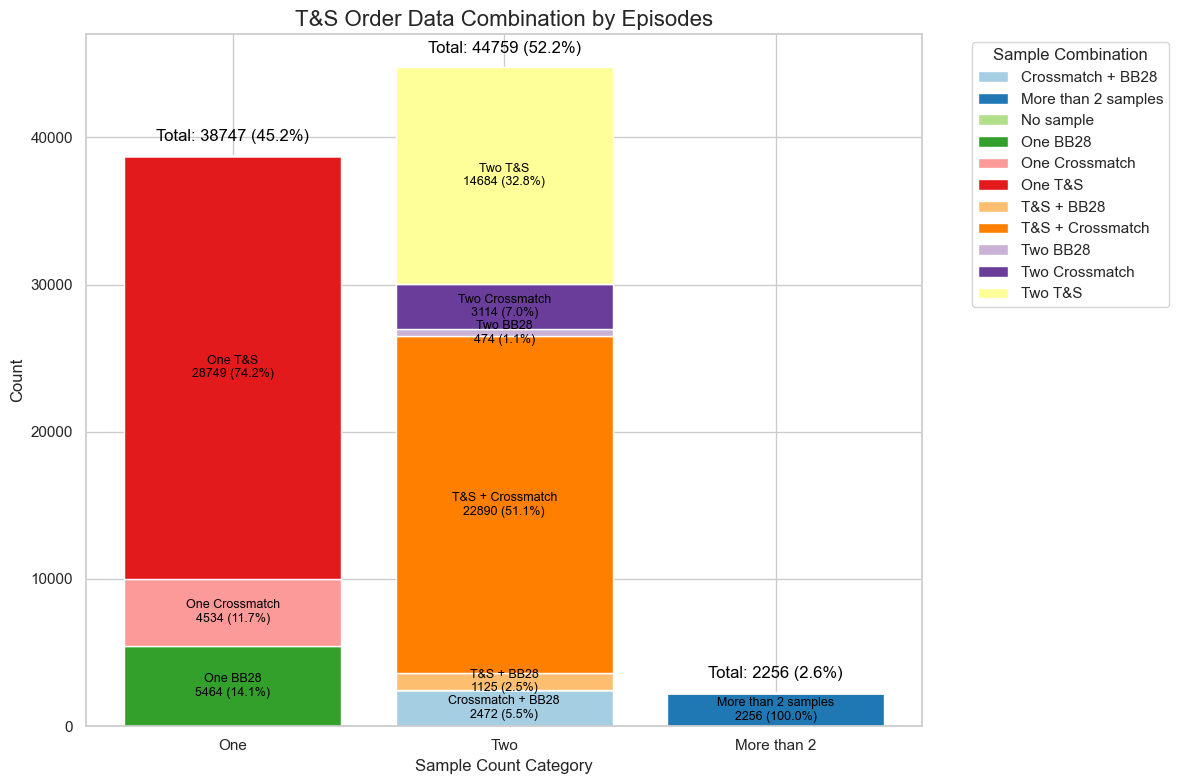

In [440]:
fig, ax = plt.subplots(figsize=(12, 8))

# Bottom position tracker for stacking bars
bottom_position = pd.Series([0] * len(combination_counts), index=combination_counts.index)

# Define colors for different sample combinations
colors = sns.color_palette("Paired", n_colors=len(combination_counts.columns))

# Sort combinations by size within each sample count category
sorted_combination_counts = combination_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)
sorted_combination_percent = combination_percent.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Plot the stacked bars with appropriate labels and colors
for i, combination in enumerate(sorted_combination_counts.columns):
    counts = sorted_combination_counts[combination]
    percentages = sorted_combination_percent[combination]
    
    # Plot each bar section, sorted by count
    ax.bar(combination_counts.index, counts, bottom=bottom_position, label=combination, color=colors[i])
    
    # Add annotations (label, raw count, and percentage) for each section
    for j, (count, percent) in enumerate(zip(counts, percentages)):
        if count > 0:
            ax.text(j, bottom_position.iloc[j] + count / 2, f"{combination}\n{int(count)} ({percent:.1f}%)", 
                    ha='center', va='center', fontsize=9, color='black')
    
    bottom_position += counts  # Update bottom position for the next stack

# Add title and labels to the plot
ax.set_title('T&S Order Data Combination by Episodes', fontsize=16)
ax.set_xlabel('Sample Count Category', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Annotate total counts with percentages at the top of each bar
total_counts = combination_counts.sum(axis=1)
total_percentages = total_counts / total_counts.sum() * 100
for i, (total, percentage) in enumerate(zip(total_counts, total_percentages)):
    ax.text(i, total + 1000, f"Total: {int(total)} ({percentage:.1f}%)", ha='center', fontsize=12, color='black')

# Display the legend outside the plot
ax.legend(title="Sample Combination", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better display
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


### Boxplot of orders associated with each episode/case

 IDs with more than 10 T&S orders:
145960    1558552424292123671
Name: deid_case_id, dtype: int64
count    249900.000000
mean          1.275522
std           0.666817
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: ts_order_count, dtype: float64


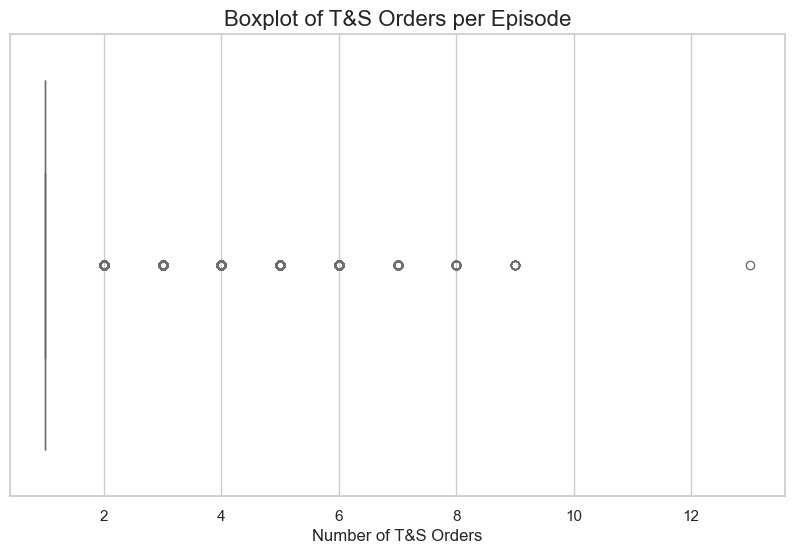

In [441]:
# Group by 'deid_case_id' and count the number of T&S orders for each episode
ts_order_count = odata.groupby('deid_case_id').size().reset_index(name='ts_order_count')

# Find the episode ids with more than 10 T&S orders
episode_ids_with_many_orders = ts_order_count[ts_order_count['ts_order_count'] > 10]['deid_case_id']

# Print the episode ids
print(" IDs with more than 10 T&S orders:")
print(episode_ids_with_many_orders) 
# Print basic statistics to look at the distribution
print(ts_order_count['ts_order_count'].describe())
# Visualize with a boxplot to detect any outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=ts_order_count['ts_order_count'], color='lightcoral')
plt.title('Boxplot of T&S Orders per Episode', fontsize=16)
plt.xlabel('Number of T&S Orders', fontsize=12)
plt.show()



In [442]:

# Locate these rows in the 'ts' dataset
ts_rows_with_many_orders = odata[odata['deid_case_id'].isin(episode_ids_with_many_orders)]

# Print the rows with more than 10 T&S orders in the 'ts' dataset
print("Rows in 'ts' dataset corresponding to episodes with more than 10 T&S orders:")
ts_rows_with_many_orders.sort_values('deid_case_id')[['deid_case_id','anes_start_tsp','sign_time','result_time','specimen_collected_time','specimen_received_time','in_room_tsp','out_of_room_tsp']]


Rows in 'ts' dataset corresponding to episodes with more than 10 T&S orders:


,deid_case_id,anes_start_tsp,sign_time,result_time,specimen_collected_time,specimen_received_time,in_room_tsp,out_of_room_tsp
277703,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-08 06:22:00+00:00,NaT,2022-11-08 17:16:00+00:00,2022-11-11 09:07:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277704,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-07 13:06:00+00:00,2022-11-07 14:04:00+00:00,2022-11-07 13:12:00+00:00,2022-11-07 13:27:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277705,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-08 09:07:00+00:00,NaT,2022-11-08 10:19:00+00:00,2022-11-11 09:07:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277706,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-07 12:27:00+00:00,NaT,2022-11-07 12:27:00+00:00,2022-11-12 09:12:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277707,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-08 04:41:00+00:00,NaT,2022-11-08 05:06:00+00:00,2022-11-10 09:06:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277708,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-08 19:10:00+00:00,NaT,2022-11-08 22:09:00+00:00,2022-11-11 09:07:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277709,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-07 14:51:00+00:00,NaT,NaT,NaT,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277710,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-07 13:00:00+00:00,2022-11-11 09:09:00+00:00,2022-11-07 13:13:00+00:00,2022-11-07 13:14:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277711,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-07 13:06:00+00:00,NaT,2022-11-07 13:07:00+00:00,2022-11-19 09:10:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00
277712,1558552424292123671,2022-11-09 23:50:00+00:00,2022-11-08 13:53:00+00:00,NaT,2022-11-08 17:16:00+00:00,2022-11-11 09:07:00+00:00,2022-11-10 00:39:00+00:00,2022-11-10 03:27:00+00:00


### Time diff

In [443]:
def plot_time_differences(data, bb28_proc_name='PRE-SURGICAL TYPE AND SCREEN (OUTPATIENTS ONLY)'):
    """
    This function calculates and plots the median time differences between key timepoints
    for all samples, BB28 samples, and non-BB28 samples, in minutes.

    Parameters:
    - data: DataFrame containing the relevant time difference columns.
    - bb28_proc_name: The value in the 'proc_name' column indicating BB28 samples (default is 'PRE-SURGICAL TYPE AND SCREEN (OUTPATIENTS ONLY)').
    
    Returns:
    - A seaborn barplot comparing the median time differences in minutes.
    """
    # Convert the time differences to minutes
    #if 'time_sign_to_collect' not in data.columns:
    data['time_sign_to_collect'] = np.where(
        (data['sign_time'].notna() & data['specimen_collected_time'].notna() & 
         ((data['specimen_collected_time'] - data['sign_time']).dt.total_seconds() > 0)),
        (data['specimen_collected_time'] - data['sign_time']).dt.total_seconds() / 60,  # Convert to minutes
        np.nan
    )
        
    #if 'time_collect_to_receive' not in data.columns:
    data['time_collect_to_receive'] = np.where(
        (data['specimen_collected_time'].notna() & data['specimen_received_time'].notna() & 
         ((data['specimen_received_time'] - data['specimen_collected_time']).dt.total_seconds() > 0)),
        (data['specimen_received_time'] - data['specimen_collected_time']).dt.total_seconds() / 60,  # Convert to minutes
        np.nan
    )
        
    #if 'time_receive_to_result' not in data.columns:
    data['time_receive_to_result'] = np.where(
        (data['specimen_received_time'].notna() & data['result_time'].notna() & 
         ((data['result_time'] - data['specimen_received_time']).dt.total_seconds() > 0)),
        (data['result_time'] - data['specimen_received_time']).dt.total_seconds()/60 ,  # Convert to minutes
        np.nan
    )

    # Create a function to calculate median and sample size
    def calculate_metrics(df):
        avg_times = {
            'Sign to Collect': np.nanmedian(df['time_sign_to_collect']),
            'Collect to Receive': np.nanmedian(df['time_collect_to_receive']),
            'Receive to Result': np.nanmedian(df['time_receive_to_result'])
        }
        
        # Calculate sample sizes (non-NaN counts)
        sample_sizes = {
            'Sign to Collect': df['time_sign_to_collect'].count(),
            'Collect to Receive': df['time_collect_to_receive'].count(),
            'Receive to Result': df['time_receive_to_result'].count()
        }
        
        return avg_times, sample_sizes

    # Calculate metrics for all samples
    avg_times_all, sample_sizes_all = calculate_metrics(data)

    # Filter for BB28 and non-BB28 samples
    bb28_df = data[data['proc_name'] == bb28_proc_name]
    non_bb28_df = data[data['proc_name'] != bb28_proc_name]

    # Calculate metrics for BB28 and non-BB28 samples
    avg_times_bb28, sample_sizes_bb28 = calculate_metrics(bb28_df)
    avg_times_non_bb28, sample_sizes_non_bb28 = calculate_metrics(non_bb28_df)

    # Create a DataFrame for seaborn plotting
    plot_data = pd.DataFrame({
        'Stage': ['Sign to Collect', 'Collect to Receive', 'Receive to Result'],
        'All Samples': list(avg_times_all.values()),
        'BB28 Samples': list(avg_times_bb28.values()),
        'Non-BB28 Samples': list(avg_times_non_bb28.values())
    })

    # Melt the DataFrame to make it suitable for seaborn's barplot function
    plot_data_melted = pd.melt(plot_data, id_vars='Stage', value_vars=['All Samples', 'BB28 Samples', 'Non-BB28 Samples'],
                               var_name='Sample Type', value_name='Average Time (Minutes)')

    # Use a pastel color palette
    pastel_palette = sns.color_palette("pastel", n_colors=len(plot_data_melted['Sample Type'].unique()))

    # Plot using seaborn for a clustered bar chart with pastel colors
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='Stage', y='Average Time (Minutes)', hue='Sample Type', data=plot_data_melted, palette=pastel_palette)

    # Annotate each bar with the value
    for i, p in enumerate(bar_plot.patches):
        height = p.get_height()
        
        # Only annotate bars that have a height greater than 0 to avoid confusion
        if height > 0:
            # Offset annotations slightly for clarity
            bar_plot.annotate(f'{int(height)} min', 
                              (p.get_x() + p.get_width() / 2., height), 
                              ha='center', va='bottom', fontsize=10, color='black')

    plt.title('Median of the Time Between Key Timepoints for All, BB28, and Non-BB28 Samples)', fontsize=14)
    plt.ylabel('Median Time Diff (Minutes)', fontsize=12)
    plt.xlabel('Stage', fontsize=12)

    # Display the legend and adjust layout
    plt.legend(title="Sample Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()


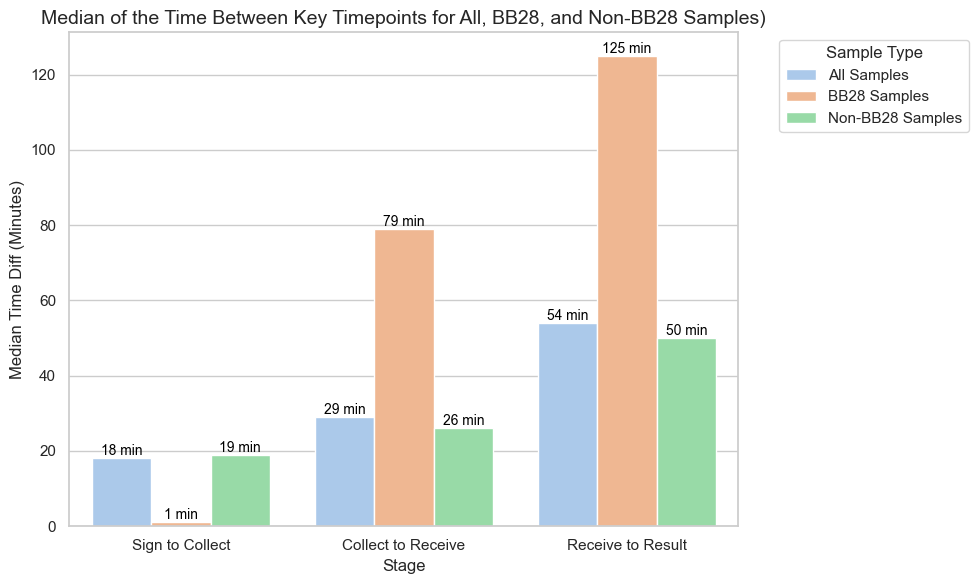

In [444]:
plot_time_differences(odata)

C:\Users\mlin2\AppData\Local\Temp\3\ipykernel_9944\3569750884.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mlin2\AppData\Local\Temp\3\ipykernel_9944\3569750884.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mlin2\AppData\Local\Temp\3\ipykernel_9944\3569750884.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

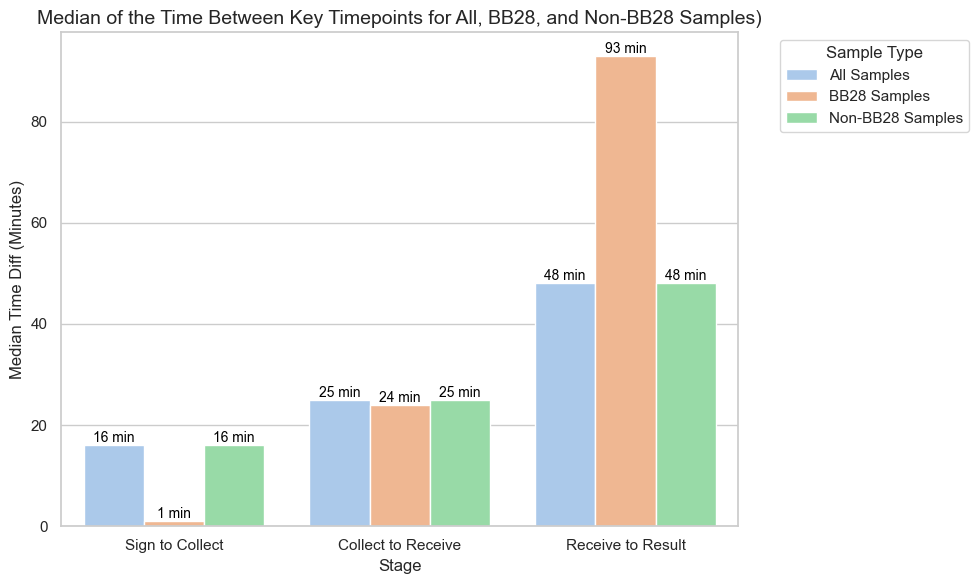

In [445]:
# Filter to include only rows where the T&S sign time is on the same date as the scheduled surgery date
filtered_odata = odata[odata['sign_time'].dt.date == odata['anes_start_tsp'].dt.date]
plot_time_differences(filtered_odata) 

In [60]:
filtered_odata.proc_name.value_counts()

proc_name
TYPE AND SCREEN                                           74126
BLOOD TYPE CONFIRMATION (REQUIRES SEPARATE PHLEBOTOMY)    42944
ADDITIONAL SPECIMEN FOR CROSSMATCH                          605
PRE-SURGICAL TYPE AND SCREEN (OUTPATIENTS ONLY)             247
CROSSMATCH RBCS                                              10
Name: count, dtype: int64

# save performance overtime

## function

In [22]:
# append the parent directory 
sys.path.append(os.path.abspath('..'))
import MSBOS_06_Analysis_Tools
# to update with any change in the source
importlib.reload(MSBOS_06_Analysis_Tools)
stat_metrics2 = MSBOS_06_Analysis_Tools.stat_metrics2


In [16]:
 
def calculate_and_track_metrics(datam, product, predicted_cols, metrics_to_melt, time_period='month'):
    """
    Calculate and track metrics for given prediction columns, using the stat_metrics2 function.
    """
    product_transfused = f'{product}_transfused'
    periop_product_units_transfused = f'periop_{product}_units_transfused'
    # Initialize an empty list to store metrics for each prediction column
    metrics_list = []  

    # Mapping of prediction columns to requested units columns
    unit_dict = {
        'req_any_before_anes': 'req_units_before_anes',
        'req_any_before_inroom': 'req_units_before_inroom',
        'req_any_before_1d_anes': 'req_units_before_1d_anes',
        'req_any_before_1d_inroom': 'req_units_before_1d_inroom',
        'req_any_before_1hr_anes': 'req_units_before_1hr_anes',
        'req_any_before_1hr_inroom': 'req_units_before_1hr_inroom',
        'req_after_inroom': 'req_units_after_inroom'
    }

    # Loop over each prediction column
    for pred_col in predicted_cols:
        datam[pred_col] = datam[pred_col].fillna(0)>0
        # Calculate metrics using stat_metrics2
        metrics = stat_metrics2(datam, pred_col, product_transfused, 'month').rename(columns={'Group':'Month'})
        # Calculate units requested but not transfused
        req_unit = unit_dict.get(pred_col, None)
        if req_unit:
            filtered_case_level = datam[datam[req_unit] > datam[periop_product_units_transfused]]
            total_units_not_transfused = (
                filtered_case_level[req_unit].sum() - filtered_case_level[periop_product_units_transfused].sum()
            )
            avg_units_not_transf_per_case = (
                (filtered_case_level[req_unit] - filtered_case_level[periop_product_units_transfused]).mean()
            )
        else:
            total_units_not_transfused = avg_units_not_transf_per_case = np.nan

        metrics['RefTime'] = pred_col
        metrics['units_req_nottranf'] = total_units_not_transfused
        metrics['units_req_nottransf_per_case'] = avg_units_not_transf_per_case

        # Append the metrics to the list
        metrics_list.append(metrics)

    # Combine all metrics into a single DataFrame
    combined_metrics = pd.concat(metrics_list, ignore_index=True)

    # Melt the DataFrame into long format for easier analysis
    metrics_by_time_long_ds = pd.melt(
        combined_metrics,
        id_vars=['Month','RefTime'],
        value_vars=metrics_to_melt,
        var_name='Metric',
        value_name='Value'
    )

    return metrics_by_time_long_ds


## clinician

### request

In [16]:
results_dict['prbc_req'].columns

Index(['deid_case_id', 'req_any_before_anes', 'req_any_before_inroom',
       'req_any_before_1d_anes', 'req_any_before_1d_inroom',
       'req_any_before_1hr_anes', 'req_any_before_1hr_inroom',
       'req_after_inroom_30m', 'req_after_inroom_1h', 'req_units_before_anes',
       'req_units_before_inroom', 'req_units_before_1d_anes',
       'req_units_before_1d_inroom', 'req_units_before_1hr_anes',
       'req_units_before_1hr_inroom', 'req_units_after_inroom_30m',
       'req_units_after_inroom_1h'],
      dtype='object')

In [17]:
datam_dict = {}

for name, one_req_final in results_dict.items():
    datam = pd.merge(data_df,one_req_final,on="deid_case_id",how='left')#.drop(columns='retrospective_or_prd')
    datam.groupby('ds')['anes_start_tsp'].agg(['min', 'max'])

    # prospective should be within 2024 for the 20241002 data 
    #print(len(datam[(datam.ds=='prospective') & (datam['anes_start_tsp']<'2024-01-01')]))

   
    #print(f'remove partial dates for train in 2021-10, # of cases: {len(datam)-before}')
    before2 = len(datam)
    datam = datam[datam.month!='2015-12']
    #print(f'remove dates in 2015-12, # of cases: {before2 - len(datam)}')

    # Check the results
    #print(f"Number of cases reassigned to 'test' in 2022-05: {datam[datam['month'] == '2022-05'].shape[0]}")
 
    # Remove all cases in 'prospective' with 'anes_start_tsp' before 2024
    #print(f"Remove cases in prospective with anes_start_tsp before 2024: {len(datam.loc[(datam['ds'] == 'prospective') & (datam['anes_start_tsp'] < '2024-01-01')])}")

    # Filter out those cases from the dataframe
    #datam = datam.loc[~((datam['ds'] == 'prospective') & (datam['anes_start_tsp'] < '2024-01-01'))]

    # Check the value counts for remaining cases
    #print(datam.ds.value_counts())

    datam_dict[f'{name}_datam'] = datam

### save month ds dictionary

In [18]:
# write the mo_ds.pkl that will be used frequently
with open('mo_ds_new.pkl', 'wb') as f:
    # save a dictionary that zips the key (datam.month) to the corresponding value (datam.ds)
    pickle.dump(dict(zip(datam_dict['prbc_req_datam'].month,datam_dict['prbc_req_datam'].ds)), f)

In [17]:
time_period='month'
predicted_cols = ['req_any_before_anes', 'req_any_before_1hr_anes','req_any_before_1d_anes',
                  'req_any_before_1d_inroom','req_any_before_inroom', 'req_any_before_1hr_inroom',
                  'req_after_inroom_30m','req_after_inroom_1h']
metrics_to_melt = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 
                   'FP%', 'FN%',
                   'units_req_nottranf', 'units_req_nottransf_per_case']

In [20]:
#calculate_and_track_metrics(datam, predicted_cols, metrics_to_melt,time_period = time_period )
# Initialize an empty DataFrame to accumulate the results
all_metrics_df = pd.DataFrame()

for blood_product in blood_product_list:
    # Calculate the metrics for the current blood product
    metrics_by_time_long_ds = calculate_and_track_metrics(
        datam_dict[f'{blood_product}_req_datam'], 
        blood_product, 
        predicted_cols, 
        metrics_to_melt, 
        time_period=time_period
    )
    
    # Add the 'Type' column
    metrics_by_time_long_ds['Type'] = 'Clinician'
    
    # Load the mo_dict from the pickle file
    with open('mo_ds_new.pkl', 'rb') as f:
        mo_dict = pickle.load(f)
    
    # Map the 'Month' column to the 'Data Split' column using mo_dict
    metrics_by_time_long_ds['Data Split'] = metrics_by_time_long_ds['Month'].map(mo_dict)
    
    # Add a 'Blood Product' column
    if blood_product == 'platelets':
        metrics_by_time_long_ds['Blood Product'] = 'platelet'
    else:
        metrics_by_time_long_ds['Blood Product'] = blood_product
    
    # Append the current DataFrame to the accumulator DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_by_time_long_ds], ignore_index=True)

# Save the accumulated DataFrame to a single CSV file
all_metrics_df.to_csv('timetrend_all_blood_products_May5.csv', index=False)


In [47]:
print(blood_product_list)

['prbc', 'ffp', 'platelets']


### ts

In [ ]:
# map ts order data onto feature data
tsdata = pd.merge(data_df,ts.drop_duplicates(),on='deid_case_id',how='left')
# remove crossmatch rbcs for two specimen calc
tsdata = tsdata[tsdata['proc_name']!='CROSSMATCH RBCS']  
ts_order_counts = tsdata.groupby(['deid_case_id', 'month','prbc_transfused','ds','race_ethnicity']).size().reset_index(name='ts_order_cnt')
# ts order
ts_order_counts['ts_any'] = (ts_order_counts['ts_order_cnt'] > 0).astype(int)
# cs order
ts_order_counts['cs_any'] = (ts_order_counts['ts_order_cnt'] >= 2).astype(int)
ts_order_counts.columns

In [24]:
def calculate_and_track_metrics_original(datam, predicted_cols, metrics_to_melt, time_period='month'):
    """
    Calculate and track metrics for given prediction columns, using the stat_metrics2 function.
    """
    # Initialize an empty list to store metrics for each prediction column
    metrics_list = []  

    # Mapping of prediction columns to requested units columns
    unit_dict = {
        'req_any_before_anes': 'req_units_before_anes',
        'req_any_before_inroom': 'req_units_before_inroom',
        'req_any_before_1d_anes': 'req_units_before_1d_anes',
        'req_any_before_1d_inroom': 'req_units_before_1d_inroom',
        'req_any_before_1hr_anes': 'req_units_before_1hr_anes',
        'req_any_before_1hr_inroom': 'req_units_before_1hr_inroom',
        'req_after_inroom': 'req_units_after_inroom'
    }

    # Loop over each prediction column
    for pred_col in predicted_cols:
        datam[pred_col] = datam[pred_col].fillna(0)>0
        # Calculate metrics using stat_metrics2
        metrics = stat_metrics2(datam, pred_col, 'prbc_transfused', 'month').rename(columns={'Group':'Month'})
        # Calculate units requested but not transfused
        req_unit = unit_dict.get(pred_col, None)
        if req_unit:
            filtered_case_level = datam[datam[req_unit] > datam['periop_prbc_units_transfused']]
            total_units_not_transfused = (
                filtered_case_level[req_unit].sum() - filtered_case_level['periop_prbc_units_transfused'].sum()
            )
            avg_units_not_transf_per_case = (
                (filtered_case_level[req_unit] - filtered_case_level['periop_prbc_units_transfused']).mean()
            )
        else:
            total_units_not_transfused = avg_units_not_transf_per_case = np.nan

        metrics['RefTime'] = pred_col
        metrics['units_req_nottranf'] = total_units_not_transfused
        metrics['units_req_nottransf_per_case'] = avg_units_not_transf_per_case

        # Append the metrics to the list
        metrics_list.append(metrics)

    # Combine all metrics into a single DataFrame
    combined_metrics = pd.concat(metrics_list, ignore_index=True)

    # Melt the DataFrame into long format for easier analysis
    metrics_by_time_long_ds = pd.melt(
        combined_metrics,
        id_vars=['Month','RefTime'],
        value_vars=metrics_to_melt,
        var_name='Metric',
        value_name='Value'
    )

    return metrics_by_time_long_ds


In [25]:

predicted_cols = ['ts_any','cs_any']
metrics_to_melt = ['Sensitivity','Specificity','NPV','PPV','FP%','FN%']
time_period='month'
ts_by_time_long = calculate_and_track_metrics_original(datam=ts_order_counts,
    predicted_cols=predicted_cols,
    metrics_to_melt=metrics_to_melt,
    time_period=time_period)
ts_by_time_long['Type'] = 'Clinician'
ts_by_time_long['Month'] = pd.to_datetime(ts_by_time_long['Month']).dt.to_period('M').astype(str)
ts_by_time_long.to_csv('timetrend_abo_ts.csv',index=False)

## Model

### prospective score

In [25]:
# prospective performance 
# Read the silent data
silent = pd.read_csv("N:/Data/20241002/silent_study_4b77285.csv").drop_duplicates()
silent = pd.merge(data_df[data_df.ds=='prospective'][['deid_case_id','ds']],silent,on='deid_case_id',how='left')

# Read the threshold from the pickle file
with open(f"N:/Models/elective_only_20230828_prbc_exclude_olddat_pt8.pkl", 'rb') as f:
    _, _, rbc_threshold = pickle.load(f)
silent['anes_start'] = pd.to_datetime(silent['anes_start'], utc=True) 
# List of timepoints
tp = ['last_score', 'an_hour_before_last_score', 'three_pm_day_before_last_score','seven_days_before_last_score']
silentf = silent[['deid_case_id', 'outcome', 'last_score_tsp']+tp].copy()
silentf['last_score_tsp'] = pd.to_datetime(silentf['last_score_tsp'], format="%Y-%m-%d %H:%M:%S.%f%z", utc=True)
silentf['Month'] = silentf['last_score_tsp'].dt.to_period('M')
# Binarize the predictions based on the threshold for each timepoint
for timepoint in tp:
    silentf[timepoint + '_predicted'] = silentf[timepoint] > rbc_threshold


C:\Users\wzhang10\.conda\envs\capstone\lib\site-packages\xgboost\core.py:160: UserWarning:

[20:58:54] WARNING: D:\bld\xgboost-split_1713397727666\work\src\gbm\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.


C:\Users\wzhang10\.conda\envs\capstone\lib\site-packages\sklearn\base.py:329: UserWarning:

Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

C:\Users\wzhang10\.con

In [26]:
# Initialize an empty DataFrame to store metrics for each month and timepoint
metrics_by_month_tp = pd.DataFrame()

# Loop through each timepoint
for timepoint in tp:
    # Set the 'predicted' column for the current timepoint
    silentf['predicted'] = silentf[timepoint + '_predicted'].astype(bool)

    # Apply stat_metrics2 for each month
    temp_metrics = (
        silentf.groupby('Month')
        .apply(lambda x: stat_metrics2(x, 'predicted', 'outcome', 'Month'))
        .reset_index()
    )

    # Add the timepoint as a column in the results
    temp_metrics['RefTime'] = timepoint

    # Concatenate the metrics to the final DataFrame
    metrics_by_month_tp = pd.concat([metrics_by_month_tp, temp_metrics], ignore_index=True)

# Melt the DataFrame into long format for easier plotting
metrics_long = pd.melt(
    metrics_by_month_tp, 
    id_vars=['Month', 'RefTime'], 
    var_name='Metric', 
    value_name='Value'
)

# Display the result
metrics_long = metrics_long[~metrics_long.Metric.isin(['level_1','Group'])]
metrics_long['Type'] = 'Model'
with open('mo_ds.pkl', 'rb') as f:
    ds_dict = pickle.load(f)
metrics_long['Data Split'] = metrics_long['Month'].astype(str).map(ds_dict)
metrics_long.to_csv('prospective_tp_score_pt8.csv',index=False)

## MSBOS

### prbc

In [1]:
dat = data_df.copy()

NameError: name 'data_df' is not defined

In [40]:
#dat['Month'] = dat.scheduled_for_dttm.dt.to_period('M').astype(str)
dat['Month'] = pd.date_range(start='2016-01', end='2024-10', freq='M')
dat['msbos_prbc'] = dat['msbos_prbc'].fillna(0) 
msbos_prbc = pd.melt(stat_metrics2(dat, 'msbos_prbc','prbc_transfused','Month'),
    id_vars = ['Group'],
        var_name='Metric',
        value_name='Value')
msbos_prbc['RefTime'] = 'prbc'

dat['msbos_ts'] = dat['msbos_ts'].fillna(0) 
msbos_ts = pd.melt(stat_metrics2(dat, 'msbos_ts','prbc_transfused','Month'),
    id_vars = ['Group'],
        var_name='Metric',
        value_name='Value')  
msbos_ts['RefTime'] = 'TS'

msbos_dat = pd.concat([msbos_prbc,msbos_ts],axis=0)
msbos_dat['Type'] = 'MSBOS'
msbos_dat.rename(columns={'Group':'Month'},inplace=True)
#msbos_dat['Data Split']=msbos_dat['Month'].map(mo_dict)
msbos_dat.to_csv('msbos_prbc.csv',index=False)

C:\Users\wzhang10\.conda\envs\capstone\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



ZeroDivisionError: division by zero

# Summary stats by data split

In [578]:

importlib.reload(MSBOS_06_Analysis_Tools)
stat_metrics2 = MSBOS_06_Analysis_Tools.stat_metrics2


In [448]:
dat = data_df.copy()

## MSBOS


### prbc

In [459]:
dat['msbos_prbc'] = dat['msbos_prbc'].fillna(0)
stat_metrics2(dat, 'msbos_prbc','prbc_transfused','ds',CI=True)

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,train,0.72,0.83,0.12,0.99,0.89,16.60,"(0.71, 0.73)","(0.83, 0.83)","(0.12, 0.13)","(0.99, 0.99)","(0.01, 0.01)","(0.16, 0.17)"
1,valid,0.74,0.85,0.11,0.99,0.63,14.72,"(0.71, 0.78)","(0.84, 0.85)","(0.1, 0.12)","(0.99, 0.99)","(0.01, 0.01)","(0.14, 0.15)"
2,test,0.72,0.84,0.11,0.99,0.75,15.25,"(0.69, 0.76)","(0.84, 0.85)","(0.1, 0.13)","(0.99, 0.99)","(0.01, 0.01)","(0.15, 0.16)"
3,prospective,0.71,0.86,0.11,0.99,0.69,13.34,"(0.67, 0.75)","(0.86, 0.87)","(0.1, 0.12)","(0.99, 0.99)","(0.01, 0.01)","(0.13, 0.14)"


### ts (can ignore tc)

In [460]:
dat['msbos_ts'] = dat['msbos_ts'].fillna(0)
stat_metrics2(dat, 'msbos_ts','prbc_transfused','ds',CI=True)

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,train,0.89,0.63,0.07,0.99,0.37,35.41,"(0.88, 0.89)","(0.63, 0.64)","(0.07, 0.08)","(0.99, 0.99)","(0.0, 0.0)","(0.35, 0.36)"
1,valid,0.89,0.69,0.07,1.00,0.27,30.01,"(0.86, 0.92)","(0.69, 0.7)","(0.06, 0.07)","(0.99, 1.0)","(0.0, 0.0)","(0.29, 0.31)"
2,test,0.88,0.69,0.07,1.00,0.33,30.11,"(0.85, 0.9)","(0.68, 0.7)","(0.07, 0.08)","(0.99, 1.0)","(0.0, 0.0)","(0.3, 0.31)"
3,prospective,0.86,0.72,0.07,1.00,0.33,27.04,"(0.83, 0.89)","(0.72, 0.73)","(0.06, 0.08)","(0.99, 1.0)","(0.0, 0.0)","(0.26, 0.28)"


In [461]:
dat['msbos_tc'] = dat['msbos_tc'].fillna(0)
stat_metrics2(dat, 'msbos_tc','prbc_transfused','ds',CI=True)

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,train,0.01,1.00,0.09,0.97,3.17,0.42,"(0.01, 0.02)","(1.0, 1.0)","(0.07, 0.11)","(0.97, 0.97)","(0.03, 0.03)","(0.0, 0.0)"
1,valid,0.02,0.99,0.08,0.98,2.44,0.54,"(0.01, 0.03)","(0.99, 1.0)","(0.04, 0.14)","(0.97, 0.98)","(0.02, 0.03)","(0.0, 0.01)"
2,test,0.01,0.99,0.05,0.97,2.70,0.52,"(0.0, 0.02)","(0.99, 1.0)","(0.02, 0.1)","(0.97, 0.97)","(0.02, 0.03)","(0.0, 0.01)"
3,prospective,0.01,1.00,0.06,0.98,2.33,0.39,"(0.0, 0.02)","(1.0, 1.0)","(0.02, 0.13)","(0.97, 0.98)","(0.02, 0.03)","(0.0, 0.0)"


## clinicians

In [542]:
datam = datam.fillna(0)

### prbc request

In [544]:
stat_metrics2(datam, 'req_any_before_anes','prbc_transfused','ds',CI=True)

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,train,0.34,0.97,0.27,0.98,2.11,2.94,"(0.33, 0.36)","(0.97, 0.97)","(0.26, 0.28)","(0.98, 0.98)","(0.02, 0.02)","(0.03, 0.03)"
1,valid,0.42,0.97,0.25,0.98,1.45,3.21,"(0.38, 0.46)","(0.96, 0.97)","(0.22, 0.28)","(0.98, 0.99)","(0.01, 0.02)","(0.03, 0.03)"
2,test,0.41,0.97,0.26,0.98,1.58,3.11,"(0.38, 0.45)","(0.97, 0.97)","(0.24, 0.29)","(0.98, 0.99)","(0.01, 0.02)","(0.03, 0.03)"
3,prospective,0.49,0.96,0.24,0.99,1.19,3.54,"(0.45, 0.53)","(0.96, 0.97)","(0.22, 0.27)","(0.99, 0.99)","(0.01, 0.01)","(0.03, 0.04)"


In [545]:
stat_metrics2(datam, 'req_any_before_inroom','prbc_transfused','ds',CI=True)
#30 minutes after inroom if out of room - in room is <= 30 minutes

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,train,0.36,0.97,0.27,0.98,2.04,3.16,"(0.35, 0.38)","(0.97, 0.97)","(0.26, 0.28)","(0.98, 0.98)","(0.02, 0.02)","(0.03, 0.03)"
1,valid,0.44,0.97,0.25,0.99,1.40,3.36,"(0.39, 0.48)","(0.96, 0.97)","(0.22, 0.27)","(0.98, 0.99)","(0.01, 0.02)","(0.03, 0.04)"
2,test,0.42,0.97,0.26,0.98,1.56,3.21,"(0.38, 0.46)","(0.96, 0.97)","(0.24, 0.29)","(0.98, 0.99)","(0.01, 0.02)","(0.03, 0.03)"
3,prospective,0.49,0.96,0.24,0.99,1.17,3.60,"(0.45, 0.54)","(0.96, 0.97)","(0.22, 0.27)","(0.99, 0.99)","(0.01, 0.01)","(0.03, 0.04)"


### ts

In [546]:
stat_metrics2(ts_order_counts, 'ts_any','prbc_transfused','ds',CI=True)

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,test,1.0,0.0,0.03,0,0.0,97.27,"(0.99, nan)","(nan, 0.0)","(0.03, 0.03)","(0, 0)","(nan, 0.0)","(0.97, 0.97)"
1,train,1.0,0.0,0.03,0,0.0,96.79,"(1.0, nan)","(nan, 0.0)","(0.03, 0.03)","(0, 0)","(nan, 0.0)","(0.97, 0.97)"
2,prospective,1.0,0.0,0.02,0,0.0,97.64,"(0.99, nan)","(nan, 0.0)","(0.02, 0.03)","(0, 0)","(nan, 0.0)","(0.97, 0.98)"
3,valid,1.0,0.0,0.02,0,0.0,97.52,"(0.99, nan)","(nan, 0.0)","(0.02, 0.03)","(0, 0)","(nan, 0.0)","(0.97, 0.98)"


### tc

In [547]:
stat_metrics2(ts_order_counts, 'cs_any','prbc_transfused','ds',CI=True)

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,test,0.70,0.84,0.11,0.99,0.82,15.59,"(0.66, 0.74)","(0.83, 0.84)","(0.1, 0.12)","(0.99, 0.99)","(0.01, 0.01)","(0.15, 0.16)"
1,train,0.69,0.82,0.11,0.99,1.00,17.16,"(0.68, 0.7)","(0.82, 0.82)","(0.11, 0.12)","(0.99, 0.99)","(0.01, 0.01)","(0.17, 0.17)"
2,prospective,0.76,0.83,0.10,0.99,0.57,16.29,"(0.72, 0.79)","(0.83, 0.84)","(0.09, 0.11)","(0.99, 0.99)","(0.0, 0.01)","(0.16, 0.17)"
3,valid,0.68,0.85,0.10,0.99,0.79,14.74,"(0.64, 0.72)","(0.84, 0.85)","(0.09, 0.11)","(0.99, 0.99)","(0.01, 0.01)","(0.14, 0.15)"


## model - prospective last score

In [470]:
silent = pd.read_csv("O:/Data/20241002/silent_study_4b77285.csv").drop_duplicates()
pro_dat = pd.merge(data_df[data_df.ds=='prospective'][['deid_case_id','ds']],silent,on='deid_case_id',how='left')
with open(f"O:/Models/elective_only_20230828_prbc_exclude_olddat_pt9.pkl", 'rb') as f:
    _, _, s_threshold = pickle.load(f)
pro_dat['last_score_predict'] = pro_dat['last_score'].fillna(0)>=s_threshold
pro_dat['outcome'] = pro_dat['outcome'].fillna(False)
stat_metrics2(pro_dat,'last_score_predict', 'outcome','ds',CI=True)


C:\Users\mlin2\.conda\envs\MSBOS\lib\site-packages\sklearn\base.py:329: UserWarning:

Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

C:\Users\mlin2\.conda\envs\MSBOS\lib\site-packages\sklearn\base.py:329: UserWarning:

Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

C:\Users\mlin2\AppData\Local\Temp\3\ipykernel_9944\3696875418.py:6: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) inste

,Group,Sensitivity,Specificity,PPV,NPV,FN%,FP%,Sensitivity_CI,Specificity_CI,PPV_CI,NPV_CI,FN%_CI,FP%_CI
0,prospective,0.85,0.89,0.15,1.0,0.34,10.79,"(0.82, 0.88)","(0.89, 0.89)","(0.14, 0.17)","(1.0, 1.0)","(0.0, 0.0)","(0.1, 0.11)"


# R/E specific table per group

## clinician prbc

In [ ]:
datam.race_

In [602]:
datam = datam.fillna(0)
stat_metrics2(datam,'req_any_before_anes','prbc_transfused','race_ethnicity',CI=True).to_clipboard()

## clinician prbc combined